### Includes

In [256]:
### load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

import wntr
import wntr_utils

### Load model and substitute demands

In [257]:
# Create a water network model
inp_file = 'minitown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

D:\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "minitown_map.inp"; added with type None, units conversion left to user



In [258]:
df_old = wntr_utils.get_demand_patterns_from_nodes(wn)


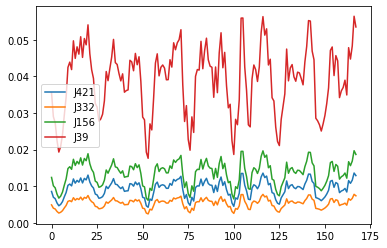

In [259]:
df_old.plot()

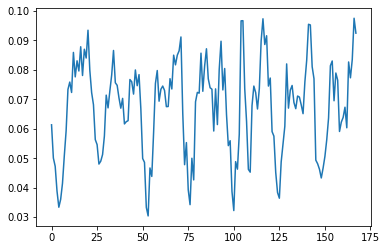

In [260]:
df_old.sum(axis=1).plot()


<<< New Demands (top 5) >>>
pat2    5.413246
pat1    4.173012
pat3    3.877113
pat4    3.577343
dtype: float64


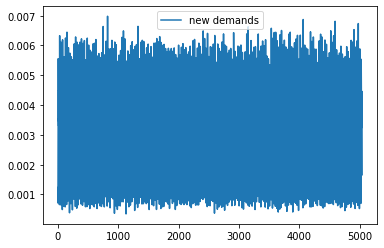

In [261]:
### load new demands
df_new = pd.read_csv('trial_24weeks.csv', index_col=0)
d_max = 0.0025
constant = 0.00
scaler = MinMaxScaler(feature_range=(0, d_max))
temp = scaler.fit_transform(df_new.values.reshape(-1,1))
df_scaled = pd.DataFrame(columns = df_new.columns, data = temp.reshape(df_new.shape))+constant
print("\n<<< New Demands (top 5) >>>")
print(df_scaled.sum().sort_values(ascending=False).head())
df_scaled.sum(axis=1).plot(label = 'new demands')
plt.legend()

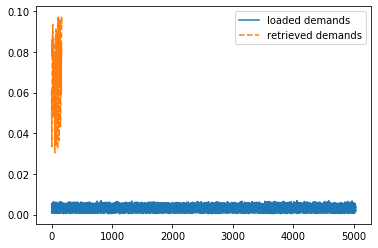

In [262]:
### substitute new demands
juncs = df_old.columns
juncs = juncs[(df_old.sum()>0).values] # these are the demand nodes
assert(len(juncs)==df_scaled.shape[1]) # check if they match columns in new demands
d_juncs = dict(zip(juncs,df_scaled.columns)) # match each demand node with new demand

# remove old patterns
for name in wn.junction_name_list:
    junc = wn.get_node(name)
    junc.demand_timeseries_list.pop()

for name in df_scaled.columns:
    wn.add_pattern(name=name, pattern=df_scaled[name].values)

for name in juncs:
    junc = wn.get_node(name)
    junc.add_demand(1,d_juncs[name])    

# check if demands coincide
df_check = wntr_utils.get_demand_patterns_from_nodes(wn)
plt.figure()
df_scaled.sum(axis=1).plot(label = 'loaded demands')
df_check.sum(axis=1).plot(label = 'retrieved demands', **{'linestyle':'dashed'})
plt.legend()

In [263]:
# Simulate hydraulics
wn.options.time.duration = 3600*24*7*20
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results = sim.run_sim()

# Graph the network
# demand_at_5hr = results.node['demand'].loc[8*3600, :]*1000
# de = wntr.graphics.plot_interactive_network(wn, title=None, node_attribute=demand_at_5hr, node_labels=True, figsize=[1080, 1024])

### Diagnostics

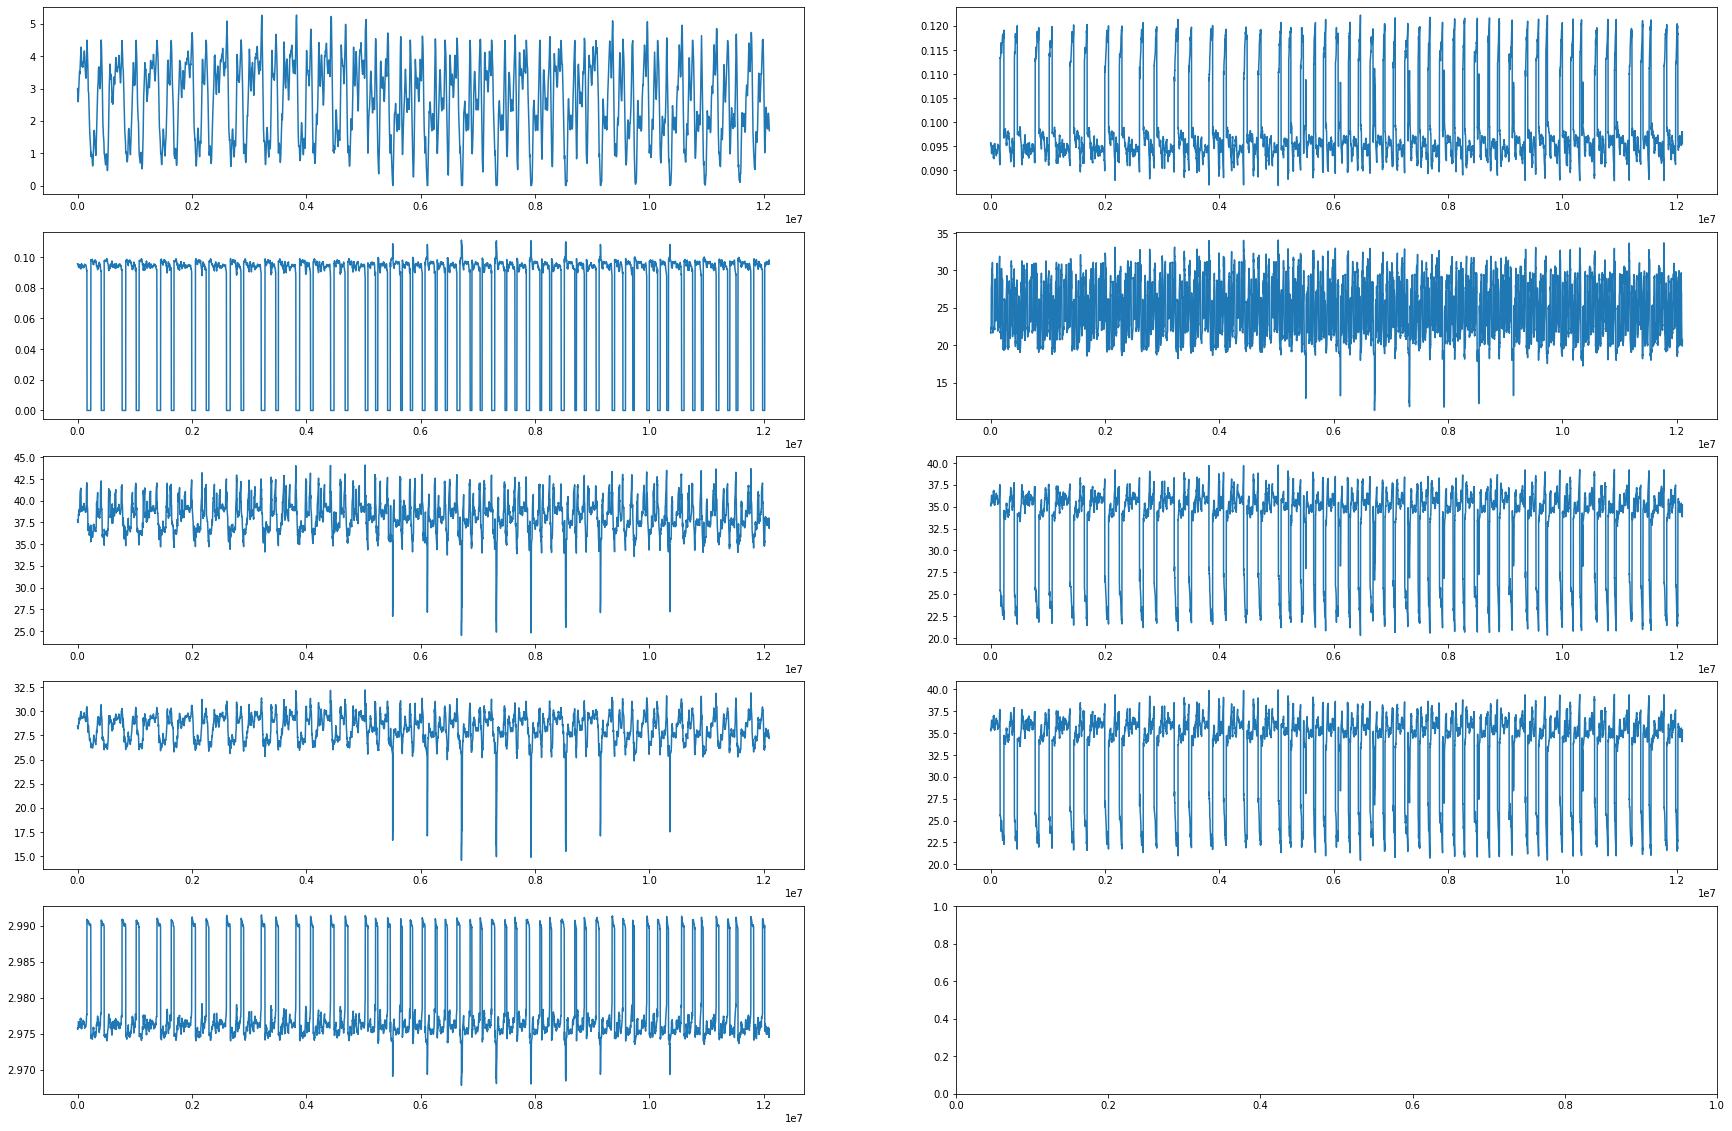

In [264]:
tanks = ['TANK']

nr = 5 
nc = 2

f, ax = plt.subplots(nr,nc,figsize=(30,20))

ax[0][0].plot(results.node['pressure']['TANK'])
ax[0][1].plot(results.link['flowrate']['PUMP1'])
ax[1][0].plot(results.link['flowrate']['PUMP2'])
ax[1][1].plot(results.node['pressure']['J332'])
ax[2][0].plot(results.node['pressure']['J421'])
ax[2][1].plot(results.node['pressure']['J156'])
ax[3][0].plot(results.node['pressure']['J39'])
ax[3][1].plot(results.node['pressure']['J269'])
ax[4][0].plot(results.node['pressure']['J280'])